# NLP: Yelp Review to Rating
### Authors: Tanvee Desai and Tanner Arrizabalaga

Hello! In this project, we will be looking over Yelp reviews (data available here: https://www.yelp.com/dataset) and utilizing ML/DL to accurately predict what the reviews star rating is based solely on text.

This project is split into the following parts
- Libraries
- EDA
- Data Cleaning
    - Stop word removal, HTML parsing, punctuation removal, etc.
    - Creation of a cleaned *and* stemmed dataset
- Model Implementation
    - Simple BOW Model Neural Network
    - LSTM
    - One vs. All LSTM Approach
- Exploring Challenges
    - Challenge 5
    - Challenge 6

### Importing necessary libraries

In [31]:
# General Libraries
import json
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# NLP
import nltk
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer


# ML/DL
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding, Conv1D, MaxPooling1D, LSTM, BatchNormalization, SpatialDropout1D, Bidirectional
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras import utils
from keras import regularizers

In [ ]:
yelp = pd.read_json("./yelp_review_training_dataset.jsonl", lines = True)
yelp.head()

How large is the data?

In [ ]:
yelp.shape

### EDA - Stars
Not too much to go off of, but let's get a general understanding of our data. How many nulls do we have?

In [ ]:
yelp.isna().sum()

In [ ]:
sns.countplot(yelp['stars'])

One thing we can potentially look at is whether or not the reviews are balanced. Let's say >=4 is positive, and <4 is negative. If we do see a significant difference in positive and negative reviews, we can balance it before training.

In [ ]:
def pos_or_neg(x):
    if x >= 4:
        return "Positive"
    else:
        return "Negative"
    
yelp['category'] = yelp['stars'].apply(pos_or_neg)

sns.countplot(yelp['category'])
num_pos = np.count_nonzero(yelp['category'] == 'Positive')
num_neg = np.count_nonzero(yelp['category'] == 'Negative')
print("Positive to negative review ratio: ", num_pos / num_neg)

There are roughly 1 and 2/3 times as many positive reviews as negative reviews. We will first try no class balancing when building the model, but may turn to class balancing later on.

### Data Cleaning - Text

In [ ]:
# Don't need to run the bottom two 

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
   
    ps = PorterStemmer()
    
    text = ' '.join(ps.stem(word) for word in text.split() if word not in STOPWORDS) # delete stopwords from text and stem
    return text
    
# yelp['text'] = yelp['text'].apply(clean_text)
# yelp.to_csv('cleaned_yelp_stemmed.csv')

# Model Implementation

### Evaluation
#### 1. Average Star Error (Average Absolute offset between predicted and true number of stars)
#### 2. Accuracy (Exact Match -- Number of exactly predicted star ratings / total samples)

In [63]:
def MAE(y_true, y_pred):
    diffs = np.abs(y_true - y_pred)
    loss = np.mean(diffs)
    return loss

def Accuracy(y_true, y_pred):
    correct = y_true == y_pred
    cor_count = np.count_nonzero(correct)
    return cor_count / len(y_true)

### Train/Test Split (Unbalanced and balanced)

In [64]:
yelp = pd.read_csv('cleaned_yelp_stemmed.csv')
yelp.head()

,Unnamed: 0,review_id,text,stars,category
0,0,Q1sbwvVQXV2734tPgoKj4Q,total bill horribl servic 8g crook actual nerv...,1,Negative
1,1,GJXCdrto3ASJOqKeVWPi6Q,ador travi hard rock new kelli cardena salon i...,5,Positive
2,2,2TzJjDVDEuAW6MR5Vuc1ug,say offic realli togeth organ friendli dr j ph...,5,Positive
3,3,yi0R0Ugj_xUx_Nek0-_Qig,went lunch steak sandwich delici caesar salad ...,5,Positive
4,4,11a8sVPMUFtaC7_ABRkmtw,today second three session paid although first...,1,Negative


In [65]:
X = yelp['text'].fillna('').values
y = yelp['stars']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### Baseline Sequential Model

In [67]:
max_words = 3000
tokenizer = text.Tokenizer(num_words=max_words, char_level=False)

tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_matrix(X_train)
X_test = tokenizer.texts_to_matrix(X_test)

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (373506, 3000)
X_test shape: (160075, 3000)
y_train shape: (373506, 5)
y_test shape: (160075, 5)


Let's save the tokenizer as well for our test submission file script.

In [68]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

Here, we are computing a single model, but in future we will optimize on several parameters, listed below
* Batch size
* Learning rate
* Gradient clipping
* Drop out
* Batch normalization
* Optimizers
* Regularization

After some tests, the main variations I noticed were from the learning rate, regularization, and the choice of the optimizer. With that being said, this baseline model will use **ADAM with a learning rate of .0001 and regularization (kernel, bias, and activity)**

In [70]:
batch_size = 1024
epochs = 5

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=.0001,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.95, amsgrad=False)

model = Sequential()
model.add(Dense(512, input_shape=(max_words,), kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
          bias_regularizer=regularizers.l2(1e-4),
          activity_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(5))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 298804 samples, validate on 74702 samples
Epoch 1/5
298804/298804 [==============================] - 17s 57us/step - loss: 1.3951 - accuracy: 0.6737 - val_loss: 1.2608 - val_accuracy: 0.7326
Epoch 2/5
298804/298804 [==============================] - 10s 34us/step - loss: 1.1595 - accuracy: 0.7372 - val_loss: 1.1207 - val_accuracy: 0.7398
Epoch 3/5
298804/298804 [==============================] - 10s 33us/step - loss: 1.0797 - accuracy: 0.7506 - val_loss: 1.0782 - val_accuracy: 0.7419
Epoch 4/5
298804/298804 [==============================] - 10s 33us/step - loss: 1.0158 - accuracy: 0.7610 - val_loss: 1.0434 - val_accuracy: 0.7422
Epoch 5/5
298804/298804 [==============================] - 10s 33us/step - loss: 0.9622 - accuracy: 0.7687 - val_loss: 1.0120 - val_accuracy: 0.7430


In [71]:
score = model.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

160075/160075 [==============================] - 11s 69us/step
Test accuracy: 0.7457191944122314


In [72]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

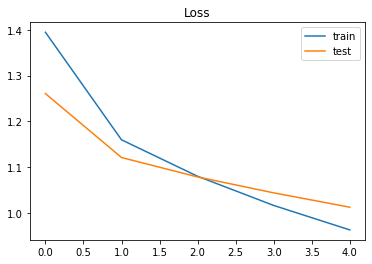

In [73]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

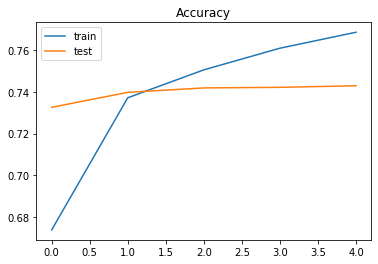

In [74]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [75]:
model.save('./models/baseline.h5')

C:\Users\Tanner\Anaconda3\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


### Now training with several parameter changes

In [ ]:
import itertools

batch_sizes = [128, 256, 512]
epochs = [5]
learning_rates = [.01, .001, .0001]
dropout = [False, True]
batch_norm = [False, True]
regularization = [True]
optimizers = ["SGD", "RMSProp", "ADAM"]

all_lists = [batch_sizes, epochs, learning_rates, dropout, batch_norm, regularization, optimizers]

params_to_test = list(itertools.product(*all_lists))
print(len(params_to_test))

In [ ]:
models = {}
histories = {}
scores = {}

for params in params_to_test:
    print(params)
    batch_size, epochs, learning_rate, dropout, batch_norm, regularization, opt = params
    
    if opt == "SGD":
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.0, nesterov=False)
    elif opt == "RMSProp":
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate, rho=0.9)
    elif opt == "ADAM":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.99, amsgrad=False)
    else:
        optimizer = keras.optimizers.Adadelta(learning_rate=learning_rate, rho=0.95)
    
    model = Sequential()
    model.add(Dense(512, input_shape=(max_words,), kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    
    # Check Batch Normalization
    if batch_norm:
        model.add(BatchNormalization())
    
    model.add(Activation('relu'))
    
    # Check Dropout
    if dropout:
        model.add(Dropout(0.2))
    
    model.add(Dense(5))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        validation_split=0.1)
    
    models[params] = model
    histories[params] = history
    
    score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
    print(score)
    
    scores[params] = score

### LSTM Model


#### Specific Data Prep

In [76]:
from sklearn.model_selection import train_test_split

X = yelp['text'].fillna('').values
y = pd.get_dummies(yelp['stars']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

max_words = 3000
maxlen = 400

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# For the LSTM, we are going to pad our sequences
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

(373506,) (373506, 5)
(160075,) (160075, 5)


#### LSTM #1

In [77]:
batch_size = 1024
epochs = 5

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=.001,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.99, amsgrad=False, clipvalue=.3)

lstm = Sequential()
lstm.add(Embedding(max_words, 128, input_length=maxlen))
lstm.add(SpatialDropout1D(0.2))
lstm.add(Conv1D(64, 5, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
          bias_regularizer=regularizers.l2(1e-4)))
lstm.add(MaxPooling1D(pool_size=4))
lstm.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm.add(BatchNormalization())
lstm.add(Dense(5, activation='sigmoid'))

lstm.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = lstm.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 298804 samples, validate on 74702 samples
Epoch 1/5
298804/298804 [==============================] - 69s 229us/step - loss: 0.8314 - accuracy: 0.6929 - val_loss: 0.7418 - val_accuracy: 0.7217
Epoch 2/5
298804/298804 [==============================] - 67s 224us/step - loss: 0.6972 - accuracy: 0.7366 - val_loss: 0.6832 - val_accuracy: 0.7418
Epoch 3/5
298804/298804 [==============================] - 67s 225us/step - loss: 0.6640 - accuracy: 0.7466 - val_loss: 0.6567 - val_accuracy: 0.7490
Epoch 4/5
298804/298804 [==============================] - 68s 228us/step - loss: 0.6406 - accuracy: 0.7541 - val_loss: 0.6441 - val_accuracy: 0.7547
Epoch 5/5
298804/298804 [==============================] - 66s 221us/step - loss: 0.6224 - accuracy: 0.7603 - val_loss: 0.6364 - val_accuracy: 0.7569


#### LSTM #1: Evaluation

In [78]:
score = lstm.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

160075/160075 [==============================] - 10s 62us/step
Test accuracy: 0.7584757208824158


In [79]:
lstm.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 400, 128)          384000    
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 400, 128)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 396, 64)           41024     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 99, 64)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               98816     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512       
_________________________________________________________________
dense_13 (Dense)             (None, 5)               

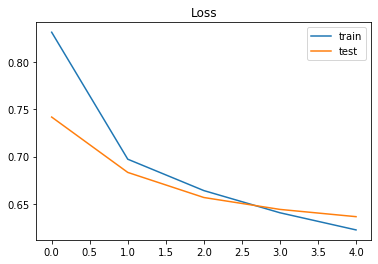

In [83]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

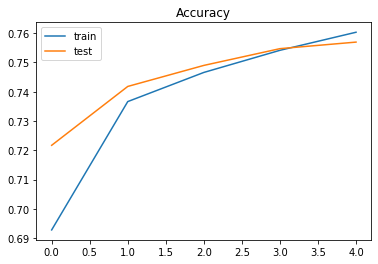

In [84]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

Let's save this model as well.

In [85]:
lstm.save('./models/lstm.h5')

### One vs. All Approach
In the one vs. all approach, it goes by the following idea:
- We will have $N$ learners for the multi-class classification problem, where $N$ is the number of classes
- For each learner $L$, we will train $L$ on our training data $X_{Train}$ and $y_{Train}$. However, $y_{Train}$ consists of only one label, making it a binary classification problem instead of multinomial
    - For instance, learner $L_1$ will still use all of $X_{Train}$, but $y_{Train}$ will now be transformed to be a binary vector $v_i$ where $i$ denotes the star rating we are attempting to predict
- Once we have concluded our training, we will then create an ensemble model (bagging) that does the following
    1. $L_1$, $L_2$, ..., $L_5$ all assign $p_i$ to each record in $X_{Test}$, where $p_i$ is the likelihood observation $x_n$ belongs to class $i$
    2. From there, our prediction is the following: $P_n = argmax(p_1, p_2, p_3, p_4, p_5)$
    
After observing the challenge datasets 5 & 6, my partner and I believe this approach is a clever way to tackle the challenges while still having a strong model.

Sources: https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/one-vs-all

In [ ]:
yelp = pd.read_csv('cleaned_yelp_stemmed.csv')

X = yelp['text'].fillna('').values
y = pd.get_dummies(yelp['stars']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

max_words = 3000
maxlen = 400

tokenizer = text.Tokenizer(num_words=max_words, char_level=False)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

#### Buidling all models

In [ ]:
stars = np.arange(1, 6)
models = {}
histories = {}
batch_size = 1024
epochs = 3

for star in stars:
    print(star)
    y_train_sub = y_train[:, star - 1]
    
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=.001,
    decay_steps=10000,
    decay_rate=0.9)

    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.99, amsgrad=False, clipvalue=.3)

    sub_lstm = Sequential()
    sub_lstm.add(Embedding(max_words, 128, input_length=maxlen))
    sub_lstm.add(SpatialDropout1D(0.2))
    sub_lstm.add(Conv1D(64, 5, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
              bias_regularizer=regularizers.l2(1e-4)))
    sub_lstm.add(MaxPooling1D(pool_size=4))
    sub_lstm.add(LSTM(128))
    sub_lstm.add(BatchNormalization())
    sub_lstm.add(Dense(8))
    sub_lstm.add(Dense(1, activation='sigmoid'))
    
    sub_lstm.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    history = sub_lstm.fit(X_train, y_train_sub,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_split=0.2)
    
    models[star] = sub_lstm
    histories[star] = sub_lstm

#### Building an ensemble model (maximization between learners) for all trained models
##### Training

In [ ]:
# Evaluating the models above (TRAIN)
y_train_und = pd.DataFrame(y_train)
y_train_true = pd.DataFrame(y_train_und.columns[np.where(y_train_und!=0)[1]]) + 1

# Unload models
lstm_1, lstm_2, lstm_3, lstm_4, lstm_5 = models[1], models[2], models[3], models[4], models[5]

## Predicting the probability for each observation each model
one_star_ps = lstm_1.predict(X_train)
two_star_ps = lstm_2.predict(X_train)
three_star_ps = lstm_3.predict(X_train)
four_star_ps = lstm_4.predict(X_train)
five_star_ps = lstm_5.predict(X_train)

data = [one_star_ps.flatten(), two_star_ps.flatten(), three_star_ps.flatten(), four_star_ps.flatten(), five_star_ps.flatten()]
cols = [1, 2, 3, 4, 5]
ps = pd.DataFrame(data=data, index=cols).T

ps["pred"] = ps.idxmax(axis=1)
ps.head()

print(MAE(ps["pred"], y_train_true[0]))
print(Accuracy(ps["pred"], y_train_true[0]))

##### Testing

In [ ]:
# Evaluating the models above (TEST)
y_test_und = pd.DataFrame(y_test)
y_test_true = pd.DataFrame(y_test_und.columns[np.where(y_test_und!=0)[1]]) + 1

# Unload models
lstm_1, lstm_2, lstm_3, lstm_4, lstm_5 = models[1], models[2], models[3], models[4], models[5]

## Predicting the probability for each observation each model
one_star_ps = lstm_1.predict(X_test)
two_star_ps = lstm_2.predict(X_test)
three_star_ps = lstm_3.predict(X_test)
four_star_ps = lstm_4.predict(X_test)
five_star_ps = lstm_5.predict(X_test)

data = [one_star_ps.flatten(), two_star_ps.flatten(), three_star_ps.flatten(), four_star_ps.flatten(), five_star_ps.flatten()]
cols = [1, 2, 3, 4, 5]
ps = pd.DataFrame(data=data, index=cols).T

ps["pred"] = ps.idxmax(axis=1)
ps.head()

print(MAE(ps["pred"], y_test_true[0]))
print(Accuracy(ps["pred"], y_test_true[0]))

#### Saving the models


In [ ]:
from keras.models import load_model

lstm_1.save("one_star.h5")
lstm_2.save("two_star.h5")
lstm_3.save("three_star.h5")
lstm_4.save("four_star.h5")
lstm_5.save("five_star.h5")

### Challenges
#### Challenge 5

In [125]:
c5 = pd.read_json("./yelp_challenge_5_with_answers.jsonl", lines = True)
print(c5.shape)
c5.head()

(500, 3)


,review_id,text,stars
0,50,I went to this campus for 1 semester. I was in...,2
1,51,I have rated it a two star based on its compar...,2
2,52,"Just like most of the reviews, we ordered and ...",2
3,53,I only go here if it is an emergency. I HATE i...,2
4,54,Rude staff. I got 60 feeder fish and about 15 ...,2


##### Quick EDA

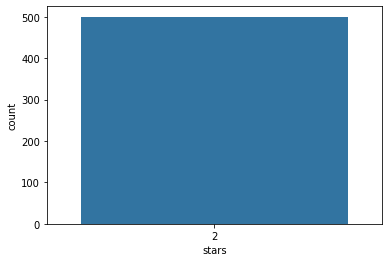

In [126]:
sns.countplot(c5['stars'])

##### Pre-processing

In [127]:
nltk.download('stopwords')

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
   
    ps = PorterStemmer()
    
    text = ' '.join(ps.stem(word) for word in text.split() if word not in STOPWORDS) # delete stopwords from text and stem
    return text
    
c5['text'] = c5['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tanner\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### Load previous tokenizer

In [128]:
X = c5['text'].fillna('').values
y = pd.get_dummies(c5['stars'])

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

max_words    
    
necc_cols = [1, 2, 3, 4, 5]
for col in necc_cols:
    if col not in y.columns:
        y[col] = 0
        
y = y[necc_cols]
y = y.values

X_baseline = tokenizer.texts_to_matrix(X)
X_lstm = tokenizer.texts_to_sequences(X)
X_lstm = pad_sequences(X_lstm, maxlen=400)

##### Load and compile models

In [129]:
from keras.models import load_model

# Baseline
baseline = load_model('./models/baseline.h5')

baseline.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# LSTM
lstm = load_model('./models/lstm.h5')

lstm.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


# One vs. all
lstm_1 = load_model('./models/one_star.h5')

lstm_1.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

lstm_2 = load_model('./models/two_star.h5')

lstm_2.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

lstm_3 = load_model('./models/three_star.h5')

lstm_3.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

lstm_4 = load_model('./models/four_star.h5')

lstm_4.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

lstm_5 = load_model('./models/five_star.h5')

lstm_5.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

##### Evaluate Models

In [132]:
# Baseline
print(baseline.evaluate(X_baseline, y))

# LSTM
print(lstm.evaluate(X_lstm, y))

# One vs. All
one_star_ps = lstm_1.predict(X_lstm)
two_star_ps = lstm_2.predict(X_lstm)
three_star_ps = lstm_3.predict(X_lstm)
four_star_ps = lstm_4.predict(X_lstm)
five_star_ps = lstm_5.predict(X_lstm)

data = [one_star_ps.flatten(), two_star_ps.flatten(), three_star_ps.flatten(), four_star_ps.flatten(), five_star_ps.flatten()]
cols = [1, 2, 3, 4, 5]
ps = pd.DataFrame(data=data, index=cols).T

ps["ova_pred"] = ps.idxmax(axis=1)

print([MAE(ps["ova_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1)), Accuracy(ps["ova_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1))])

500/500 [==============================] - 0s 70us/step
[2.1080394525527955, 0.25999999046325684]
500/500 [==============================] - 0s 544us/step
[1.7830161743164064, 0.20999999344348907]
[0.904, 0.358]


##### Attempt Ensemble

In [150]:
# Baseline
baseline_preds = pd.DataFrame(baseline.predict(X_baseline), columns=cols)
baseline_preds['baseline_pred'] = baseline_preds.idxmax(axis=1)

# LSTM
lstm_preds = pd.DataFrame(lstm.predict(X_lstm), columns=cols)
lstm_preds['lstm_pred'] = lstm_preds.idxmax(axis=1)

# One vs. all
ova_preds = ps

all_preds = pd.DataFrame([baseline_preds['baseline_pred'], lstm_preds['lstm_pred'], ova_preds['ova_pred']]).T
all_preds["final_pred"] = all_preds.mode(axis=1)[0]

print([MAE(all_preds["final_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1)), Accuracy(all_preds["final_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1))])

[0.936, 0.27]


##### Misc.

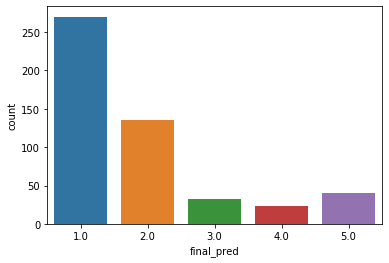

In [151]:
sns.countplot(all_preds["final_pred"])

### Challenges
#### Challenge 6

In [152]:
c6 = pd.read_json("./yelp_challenge_6_with_answers.jsonl", lines = True)
print(c6.shape)
c6.head()

(500, 3)


,review_id,text,stars
0,60,Amazing for Trees\n\n$20 for a 5 gallon . I wi...,5
1,61,How the hell can Taco Bell be closed before mi...,5
2,62,I actually had no intention of visiting this p...,5
3,63,Yesterday around 3:30 pm I was driving west on...,5
4,64,DR FITZMAURICE did surgery on both hands on th...,5


##### Quick EDA

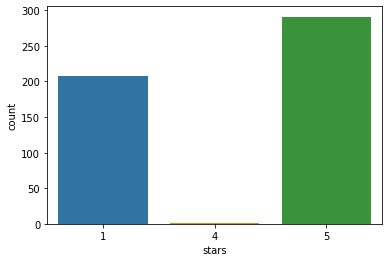

In [153]:
sns.countplot(c6['stars'])

##### Pre-processing

In [154]:
nltk.download('stopwords')

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
   
    ps = PorterStemmer()
    
    text = ' '.join(ps.stem(word) for word in text.split() if word not in STOPWORDS) # delete stopwords from text and stem
    return text
    
c6['text'] = c6['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tanner\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### Load previous tokenizer

In [155]:
X = c6['text'].fillna('').values
y = pd.get_dummies(c6['stars'])

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

max_words    
    
necc_cols = [1, 2, 3, 4, 5]
for col in necc_cols:
    if col not in y.columns:
        y[col] = 0
        
y = y[necc_cols]
y = y.values

X_baseline = tokenizer.texts_to_matrix(X)
X_lstm = tokenizer.texts_to_sequences(X)
X_lstm = pad_sequences(X_lstm, maxlen=400)

##### Load and compile models

In [156]:
from keras.models import load_model

# Baseline
baseline = load_model('./models/baseline.h5')

baseline.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# LSTM
lstm = load_model('./models/lstm.h5')

lstm.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


# One vs. all
lstm_1 = load_model('./models/one_star.h5')

lstm_1.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

lstm_2 = load_model('./models/two_star.h5')

lstm_2.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

lstm_3 = load_model('./models/three_star.h5')

lstm_3.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

lstm_4 = load_model('./models/four_star.h5')

lstm_4.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

lstm_5 = load_model('./models/five_star.h5')

lstm_5.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

C:\Users\Tanner\Anaconda3\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


##### Evaluate Models

In [157]:
# Baseline
print(baseline.evaluate(X_baseline, y))

# LSTM
print(lstm.evaluate(X_lstm, y))

# One vs. All
one_star_ps = lstm_1.predict(X_lstm)
two_star_ps = lstm_2.predict(X_lstm)
three_star_ps = lstm_3.predict(X_lstm)
four_star_ps = lstm_4.predict(X_lstm)
five_star_ps = lstm_5.predict(X_lstm)

data = [one_star_ps.flatten(), two_star_ps.flatten(), three_star_ps.flatten(), four_star_ps.flatten(), five_star_ps.flatten()]
cols = [1, 2, 3, 4, 5]
ps = pd.DataFrame(data=data, index=cols).T

ps["ova_pred"] = ps.idxmax(axis=1)

print([MAE(ps["ova_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1)), Accuracy(ps["ova_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1))])

500/500 [==============================] - 0s 158us/step
[2.2713688888549806, 0.4259999990463257]
500/500 [==============================] - 0s 726us/step
[2.026241868019104, 0.43799999356269836]
[2.048, 0.438]


##### Attempt Ensemble

In [158]:
# Baseline
baseline_preds = pd.DataFrame(baseline.predict(X_baseline), columns=cols)
baseline_preds['baseline_pred'] = baseline_preds.idxmax(axis=1)

# LSTM
lstm_preds = pd.DataFrame(lstm.predict(X_lstm), columns=cols)
lstm_preds['lstm_pred'] = lstm_preds.idxmax(axis=1)

# One vs. all
ova_preds = ps

all_preds = pd.DataFrame([baseline_preds['baseline_pred'], lstm_preds['lstm_pred'], ova_preds['ova_pred']]).T
all_preds["final_pred"] = all_preds.mode(axis=1)[0]

print([MAE(all_preds["final_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1)), Accuracy(all_preds["final_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1))])

[2.11, 0.444]


##### Misc.

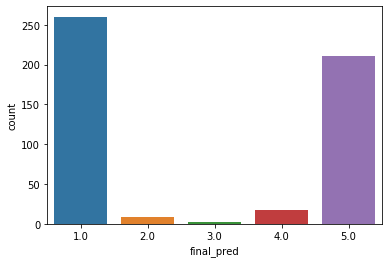

In [159]:
sns.countplot(all_preds["final_pred"])